Importation des bibliothèques

In [1]:
import os
import glob
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import csv
from sklearn import preprocessing
from sklearn.metrics import precision_score


Importation du corpus train et test pour la classe malade et sain

In [5]:
def load_and_preprocess_data(folder_path, label, img_rows=28, img_cols=28):
    images = []
    labels = []

    for filename in folder_path:

        img = cv2.imread(filename, 0).astype(np.uint8)
        img = cv2.resize(img, (img_rows, img_cols))
        images.append(img.flatten())
        labels.append(label)

    return images, labels
list_malade = glob.glob('malade_mfcc_glides/test/*')
list_ok = glob.glob('sain_mfcc_glides/test/*')
list_malade_train = glob.glob('malade_mfcc_glides/train/*')
list_ok_train = glob.glob('sain_mfcc_glides/train/*')


# 'malade' train
malade_train_images, malade_train_labels = load_and_preprocess_data(list_malade_train, label=0)

# 'non_malade' train
non_malade_train_images, non_malade_train_labels = load_and_preprocess_data(list_ok_train, label=1)

# 'malade' test
malade_test_images, malade_test_labels = load_and_preprocess_data(list_malade, label=0)

# 'non_malade' test
non_malade_test_images, non_malade_test_labels = load_and_preprocess_data(list_ok, label=1)


x_train = np.concatenate([malade_train_images, non_malade_train_images], axis=0)
y_train = np.concatenate([malade_train_labels, non_malade_train_labels], axis=0)

x_test = np.concatenate([malade_test_images, non_malade_test_images], axis=0)
y_test = np.concatenate([malade_test_labels, non_malade_test_labels], axis=0)

scaler = preprocessing.StandardScaler().fit(x_train)
x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)


Créer et entraîner le modèle SVM et visualiser la matrice de confusion. Dans cette approche, nous avons sélectionné les paramètres par défaut, en utilisant un noyau radial (RBF) avec une régularisation C=1 et une fonction de noyau gaussienne. Nous avons tout de même modifié la régularisation à 10 mais cela a fait chuter le modèle au vu du nombre de données assez faible. Le choix de gamma est une option pratique lorsque nous ne souhaitons pas spécifier manuellement la valeur de gamma, mais que nous préférons que le modèle l'ajuste automatiquement en fonction du nombre de caractéristiques de nos données.

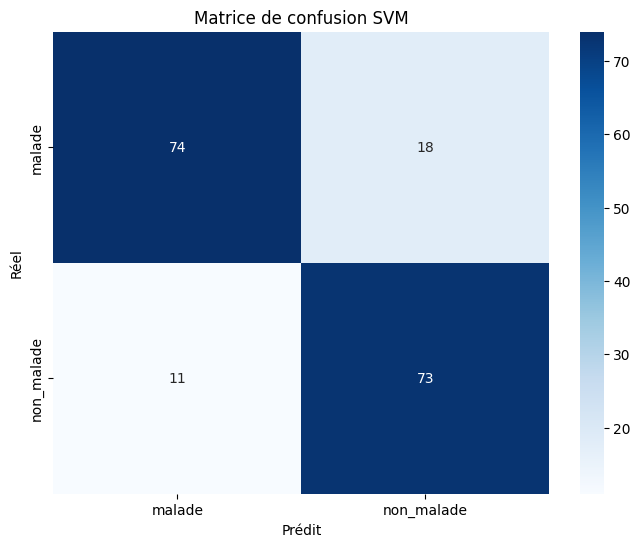

Precision: 0.8022


In [15]:
svm_model = SVC(kernel='rbf', C=1, gamma='scale') 
svm_model.fit(x_train_scaled, y_train)

# Prédictions
y_pred_svm = svm_model.predict(x_test_scaled)

# Matrice de confusion
conf_mat_svm = confusion_matrix(y_test, y_pred_svm)

# Visualiser
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat_svm, annot=True, fmt='d', cmap='Blues', xticklabels=['malade', 'non_malade'], yticklabels=['malade', 'non_malade'])
plt.title('Matrice de confusion SVM')
plt.xlabel('Prédit')
plt.ylabel('Réel')
plt.show()

# Calculer precision
precision = precision_score(y_test, y_pred_svm)
print(f'Precision: {precision:.4f}')

les données mal classées

In [17]:
malade_image_names = [os.path.basename(filename) for filename in list_malade_train]
non_malade_image_names = [os.path.basename(filename) for filename in list_ok_train]

# Sauvegarder les données mal classées dans un fichier CSV
misclassified_data_svm = []
for i in range(len(y_test)):
    if y_test[i] != y_pred_svm[i]:
        actual_class = 'malade' if y_test[i] == 0 else 'non_malade'
        predicted_class = 'malade' if y_pred_svm[i] == 0 else 'non_malade'
        image_name = malade_image_names[i] if y_test[i] == 0 else non_malade_image_names[i - len(malade_image_names)]
        misclassified_data_svm.append([image_name, actual_class, predicted_class])

csv_file_path_svm = 'misclassified_data_svm.csv'
header_svm = ['Nom de l\'image', 'Classe Réelle', 'Classe Prédite']

with open(csv_file_path_svm, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(header_svm)
    writer.writerows(misclassified_data_svm)

print(f"Données mal classées sauvegardées dans le fichier CSV : {csv_file_path_svm}")

# Afficher les données mal classées
res_svm = pd.DataFrame(misclassified_data_svm)
print(res_svm)

Données mal classées sauvegardées dans le fichier CSV : misclassified_data_svm.csv
                                                    0           1           2
0   SCA_F_AB03_2017_01_02_ModuleTransitions_aj1.tx...      malade  non_malade
1   SCA_F_AB03_2017_01_02_ModuleTransitions_wi4.tx...      malade  non_malade
2   SCA_F_AB08_2020_10_26_ModuleTransitions_wi4.tx...      malade  non_malade
3   SCA_F_AB10_2020_10_28_ModuleTransitions_aj2.tx...      malade  non_malade
4   SCA_F_AB10_2020_10_28_ModuleTransitions_aj3.tx...      malade  non_malade
5   SCA_F_AB10_2020_10_28_ModuleTransitions_uj2.tx...      malade  non_malade
6   SCA_F_AB10_2020_10_28_ModuleTransitions_wi4.tx...      malade  non_malade
7   SCA_F_AB20_2020_11_11_ModuleTransitions_aj4.tx...      malade  non_malade
8   SCA_F_AB20_2020_11_11_ModuleTransitions_uj1.tx...      malade  non_malade
9   SCA_F_AB20_2020_11_11_ModuleTransitions_uj2.tx...      malade  non_malade
10  SCA_F_AB21_2020_11_12_ModuleTransitions_uj4.tx...      

Nous pouvons voir que le modèle a plus de mal à classer les malades dans la bonne classe. Contrairement au CNN il se trompe sur d'autres types de locuteurs, majoritairement des locuteurs atteints moyennement. C'est intéressant car cela veut dire qu'il s'en sort mieux pour les peu atteints. Même si globalement nous perdons quelques pourcentages de performances par rapport au CNN.

De plus, Monsieur Audibert a souligné la possibilité que le SVM présente une faible sensibilité à l'ordre des pixels dans l'image. Nous avons donc regarder si le SVM dans ce cas présent était insensible ou non. Ses performances ont chuté encore plus que le CNN qui lui s'est montré robuste lorsque nous effections le même prétraitement ( une perte de 10 \% pour le CNN contre 20\% pour le SVM). Donc nous avons preservé les données initiales et les avons traité de la même manière pour les deux types de modèles c'est à dire sans mélanger les pixels de l'image dès le prétraitement dans les vecteurs.
Vous trouverez ci-dessous le test.

In [4]:
def load_and_preprocess_data(folder_path, label, img_rows=28, img_cols=28):
    images = []
    labels = []

    for filename in folder_path:

        img = cv2.imread(filename, 0).astype(np.uint8)
        img = cv2.resize(img, (img_rows, img_cols))
        images.append(img.flatten())
        labels.append(label)

    return images, labels
list_malade = glob.glob('malade_mfcc_glides/test/*')
list_ok = glob.glob('sain_mfcc_glides/test/*')
list_malade_train = glob.glob('malade_mfcc_glides/train/*')
list_ok_train = glob.glob('sain_mfcc_glides/train/*')


# 'malade' train
malade_train_images, malade_train_labels = load_and_preprocess_data(list_malade_train, label=0)

# 'non_malade' train
non_malade_train_images, non_malade_train_labels = load_and_preprocess_data(list_ok_train, label=1)

# 'malade' test
malade_test_images, malade_test_labels = load_and_preprocess_data(list_malade, label=0)

# 'non_malade' test
non_malade_test_images, non_malade_test_labels = load_and_preprocess_data(list_ok, label=1)


x_train = np.concatenate([malade_train_images, non_malade_train_images], axis=0)
y_train = np.concatenate([malade_train_labels, non_malade_train_labels], axis=0)

x_test = np.concatenate([malade_test_images, non_malade_test_images], axis=0)
y_test = np.concatenate([malade_test_labels, non_malade_test_labels], axis=0)
for i in range(len(x_train)):
    np.random.shuffle(x_train[i])

# Mélanger les pixels à l'intérieur de chaque vecteur dans x_test
for i in range(len(x_test)):
    np.random.shuffle(x_test[i])
scaler = preprocessing.StandardScaler().fit(x_train)
x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)
# Mélanger les pixels à l'intérieur de chaque vecteur dans x_train


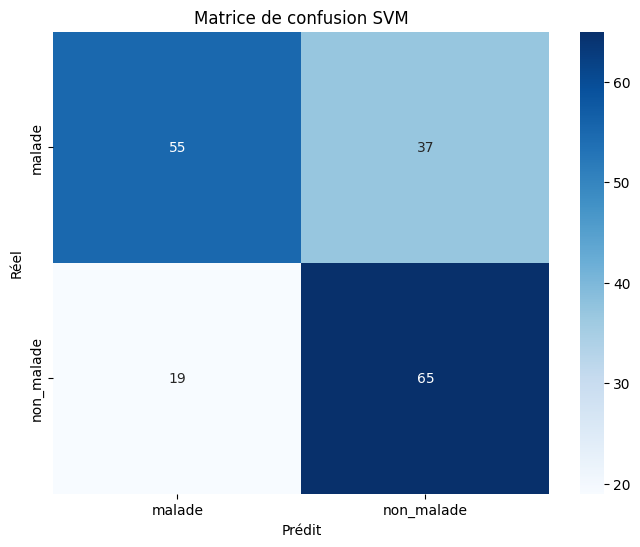

Precision: 0.6373


In [5]:
svm_model = SVC(kernel='rbf', C=1, gamma='scale') 
svm_model.fit(x_train_scaled, y_train)

# Prédictions
y_pred_svm = svm_model.predict(x_test_scaled)

# Matrice de confusion
conf_mat_svm = confusion_matrix(y_test, y_pred_svm)

# Visualiser
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat_svm, annot=True, fmt='d', cmap='Blues', xticklabels=['malade', 'non_malade'], yticklabels=['malade', 'non_malade'])
plt.title('Matrice de confusion SVM')
plt.xlabel('Prédit')
plt.ylabel('Réel')
plt.show()

# Calculer precision
precision = precision_score(y_test, y_pred_svm)
print(f'Precision: {precision:.4f}')